In [1]:
# import os, certifi
#
# os.environ["SSL_CERT_FILE"] = certifi.where()
# os.environ["REQUESTS_CA_BUNDLE"] = os.environ["SSL_CERT_FILE"]

# import torch
# from torch import nn
# import torch.optim as optim
# from torchvision import datasets, transforms, utils
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# import numpy as np
#
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Baseline hyperparameters
latent_dim = 100
hidden_dim = 64
image_size = 28 # FashionMNIST 28x28
batch_size = 128
lr_g = 2e-4
lr_d = 2e-4

beta1, beta2 = 0.5, 0.999
num_epochs = 30

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

len(train_dataset), len(train_loader)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 193kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.59MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.4MB/s]


(60000, 468)

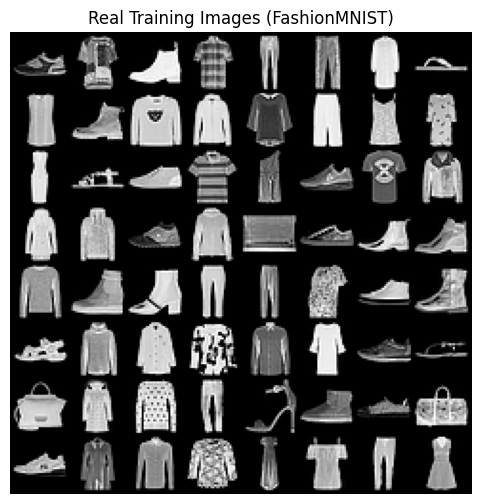

In [3]:
# Visualizing some real samples
real_batch = next(iter(train_loader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Real Training Images (FashionMNIST)")
plt.imshow(
    utils.make_grid(real_batch[0][:64], padding=2, normalize=True)
    .cpu()
    .permute(1, 2, 0)
)
plt.show()

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=64, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, hidden_dim * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            # state size. (hidden_dim*4) x 4 x 4
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # state size. (hidden_dim*2) x 7 x 7
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # state size. (hidden_dim) x 14 x 14
            nn.ConvTranspose2d(hidden_dim, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (img_channels) x 28 x 28
        )

    def forward(self, z):
        # z: (batch_size, latent_dim) -> (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            # input is (img_channels) x 28 x 28
            nn.Conv2d(img_channels, hidden_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim) x 14 x 14
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*2) x 7 x 7
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*4) x 4 x 4
            nn.Conv2d(hidden_dim * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(latent_dim=latent_dim, hidden_dim=hidden_dim, img_channels=1).to(device)
D = Discriminator(img_channels=1, hidden_dim=hidden_dim).to(device)

G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(
    G.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

optimizer_D = optim.Adam(
    D.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

In [6]:
#Visualizing generated samples helper
def show_fake_samples(epoch, fixed_noise, nrow=8):
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise.to(device))
    G.train()
    fake = (fake + 1) / 2.0  # back to [0, 1] for display
    grid = utils.make_grid(fake, nrow=nrow)
    plt.figure(figsize=(6, 6))
    plt.title(f"Generated samples at epoch {epoch}")
    plt.axis('off')
    plt.imshow(grid.cpu().permute(1, 2, 0).squeeze())
    plt.show()


fixed_noise = torch.randn(64, latent_dim, device=device)

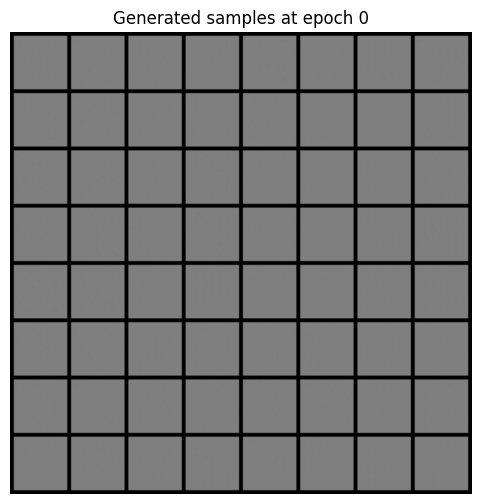

In [7]:
show_fake_samples(0, fixed_noise)

Epoch [1/30]  D_loss: 0.2590  G_loss: 3.1692


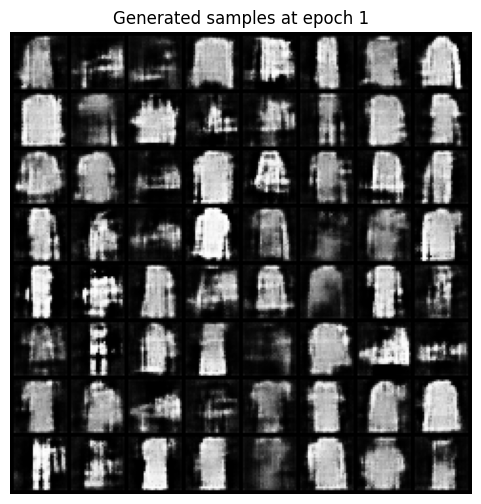

Epoch [2/30]  D_loss: 0.4388  G_loss: 1.9219


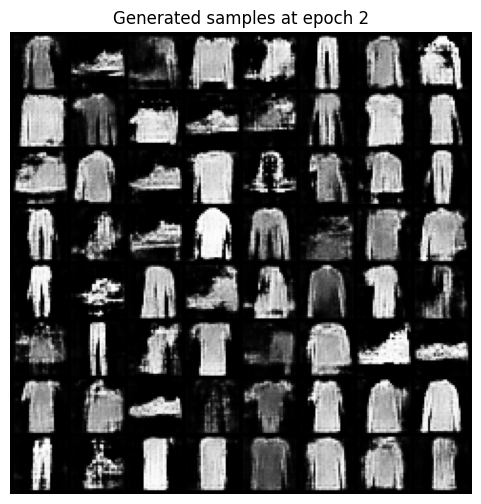

Epoch [3/30]  D_loss: 0.4703  G_loss: 1.7078


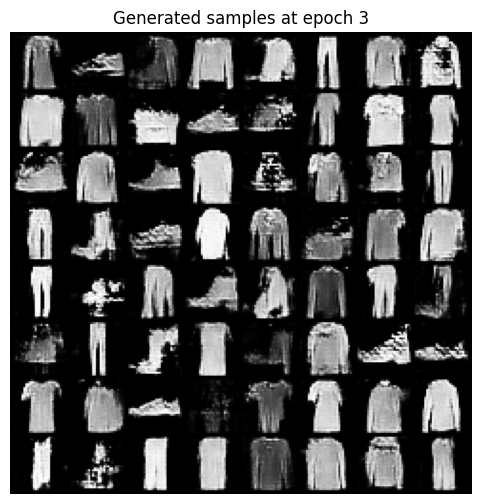

Epoch [4/30]  D_loss: 0.8413  G_loss: 0.6321


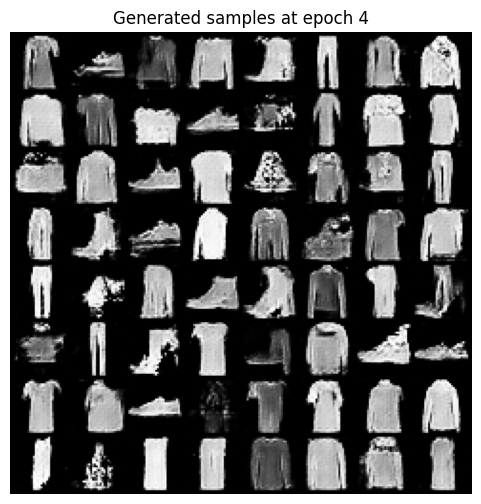

Epoch [5/30]  D_loss: 3.8519  G_loss: 3.1332


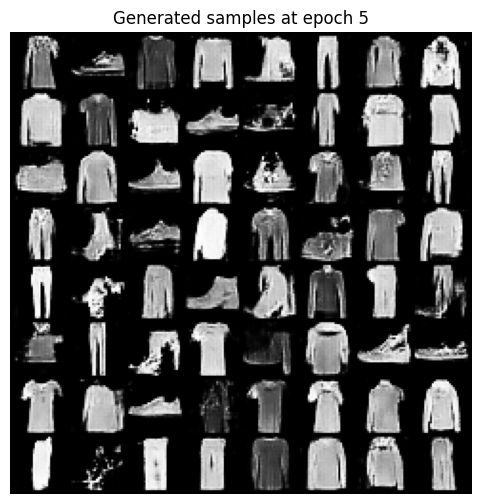

Epoch [6/30]  D_loss: 1.1345  G_loss: 0.8813


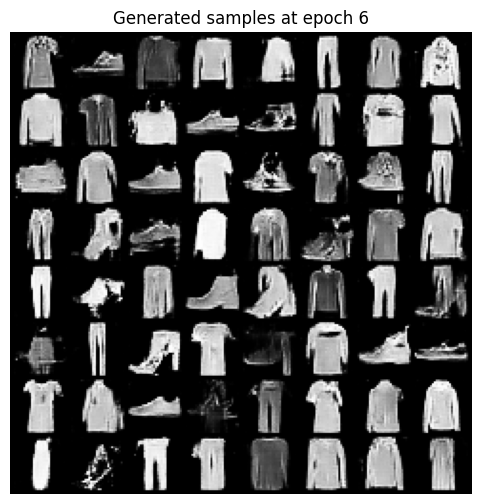

Epoch [7/30]  D_loss: 0.7824  G_loss: 1.8370


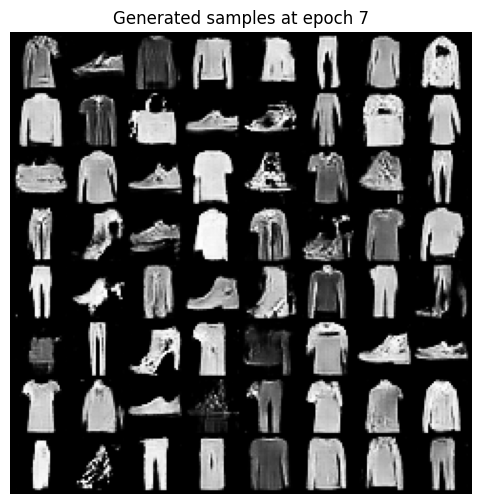

Epoch [8/30]  D_loss: 0.6364  G_loss: 2.4450


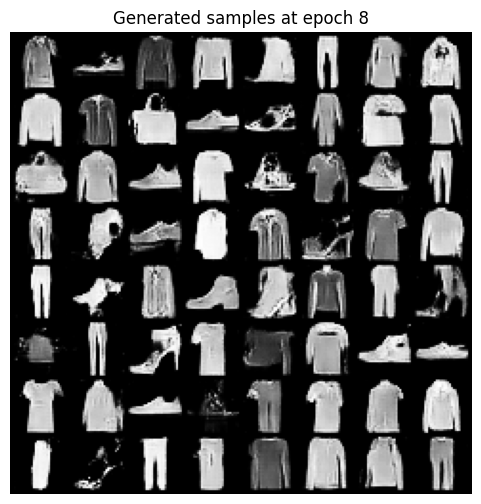

Epoch [9/30]  D_loss: 0.5437  G_loss: 0.8720


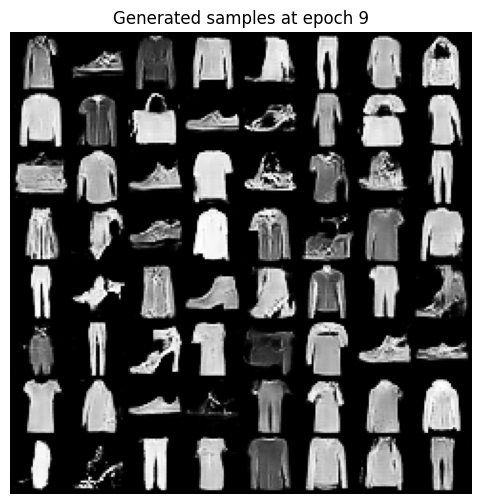

Epoch [10/30]  D_loss: 0.5865  G_loss: 2.2437


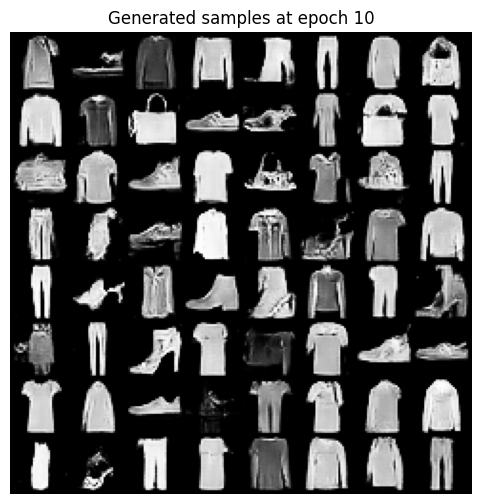

Epoch [11/30]  D_loss: 0.7052  G_loss: 1.7661


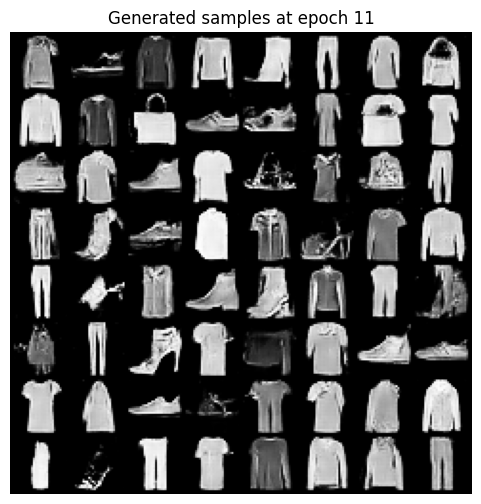

Epoch [12/30]  D_loss: 0.8844  G_loss: 1.3664


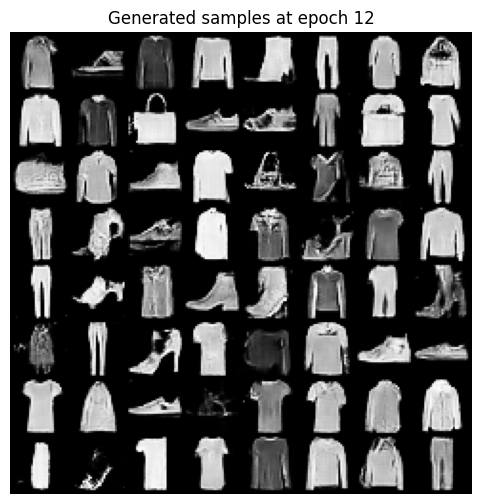

Epoch [13/30]  D_loss: 0.7585  G_loss: 1.7726


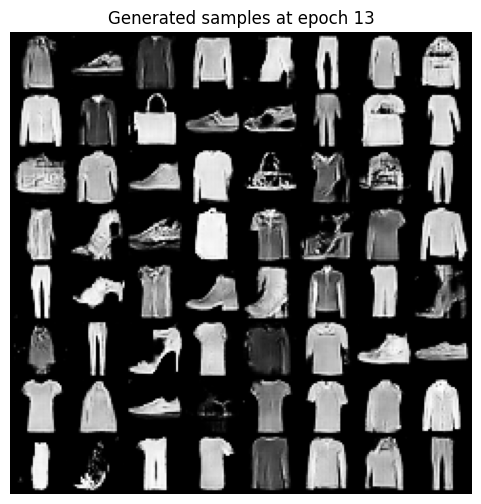

Epoch [14/30]  D_loss: 0.6451  G_loss: 2.2254


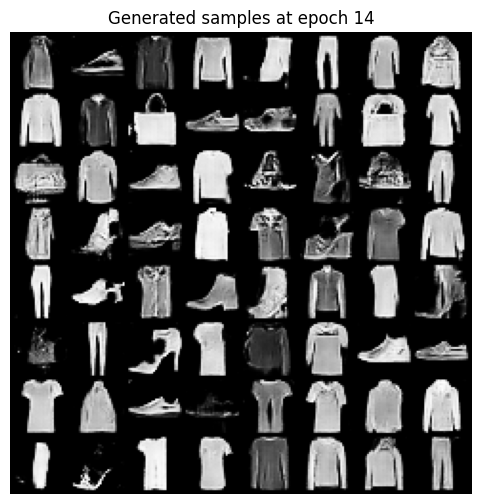

Epoch [15/30]  D_loss: 0.6923  G_loss: 2.3632


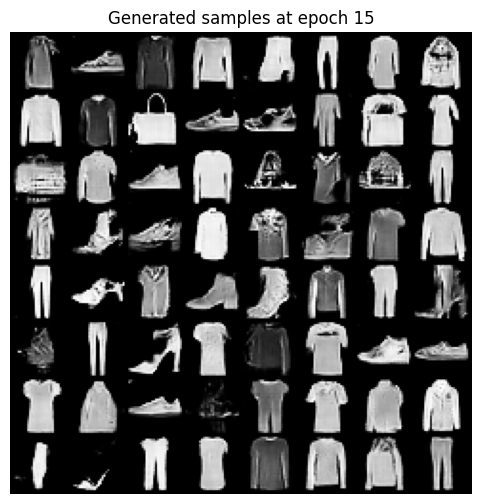

Epoch [16/30]  D_loss: 0.6581  G_loss: 1.4799


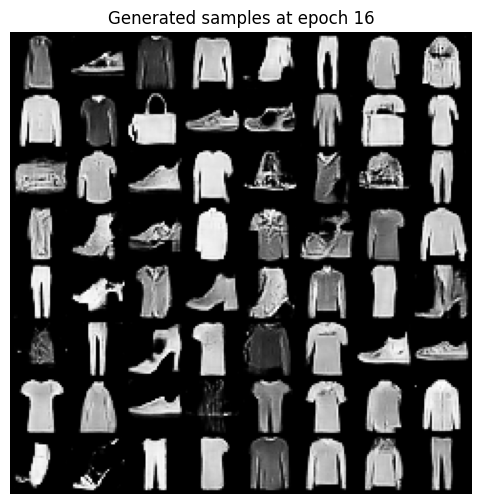

Epoch [17/30]  D_loss: 0.6343  G_loss: 2.0037


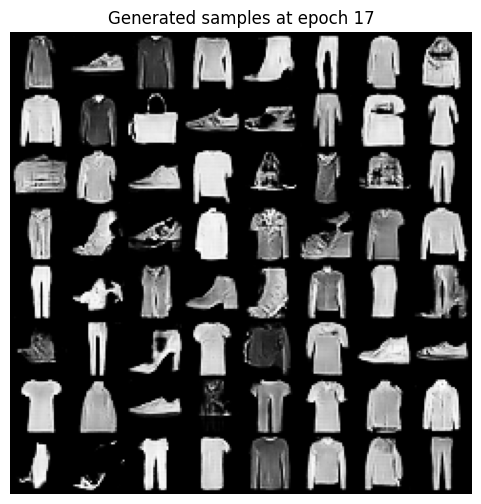

Epoch [18/30]  D_loss: 0.6547  G_loss: 1.7694


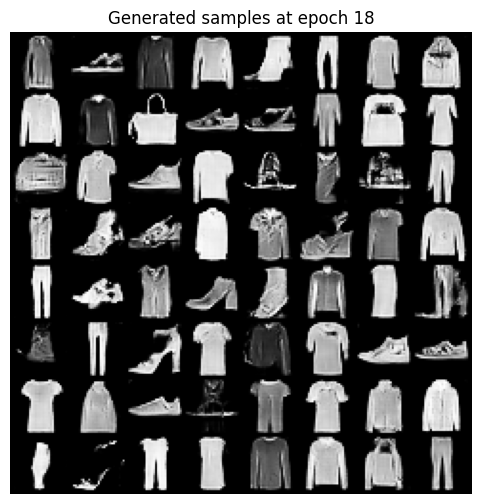

Epoch [19/30]  D_loss: 0.4752  G_loss: 1.5802


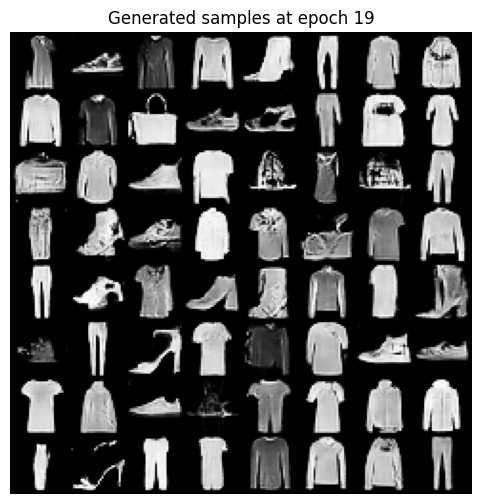

Epoch [20/30]  D_loss: 0.7524  G_loss: 1.2651


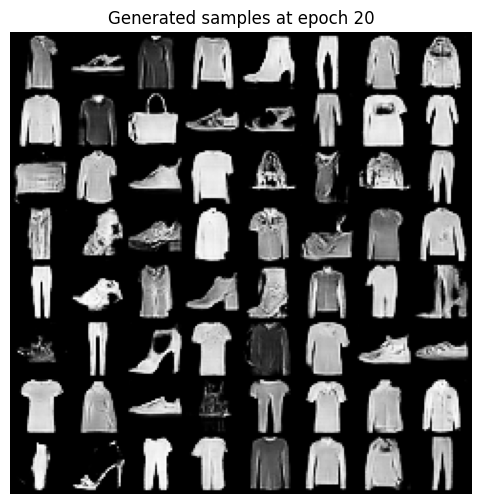

Epoch [21/30]  D_loss: 0.6565  G_loss: 1.2515


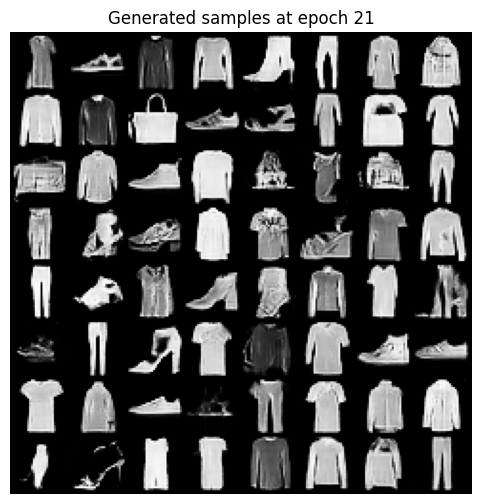

Epoch [22/30]  D_loss: 0.6240  G_loss: 2.4649


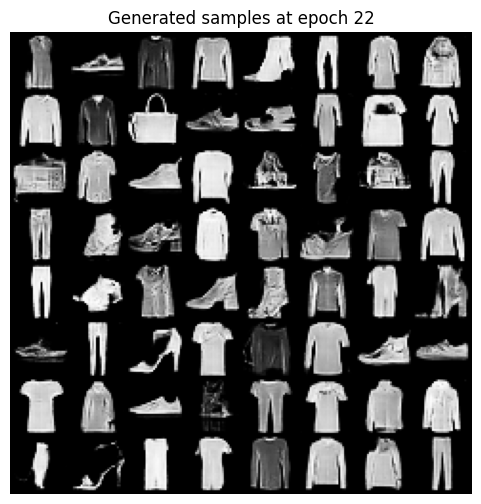

Epoch [23/30]  D_loss: 0.5664  G_loss: 1.9412


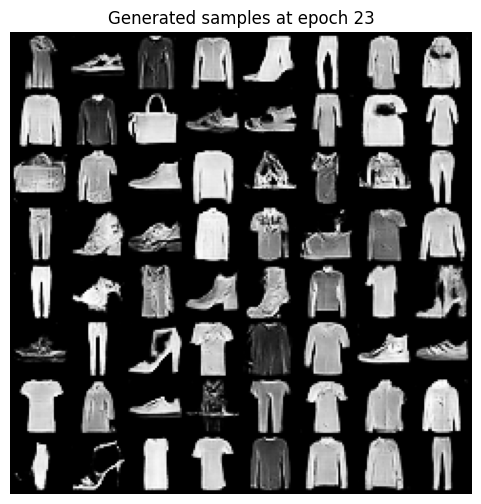

Epoch [24/30]  D_loss: 0.6713  G_loss: 2.1901


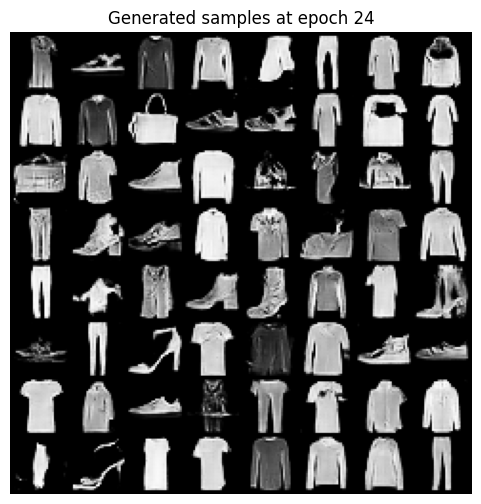

Epoch [25/30]  D_loss: 0.5526  G_loss: 2.3060


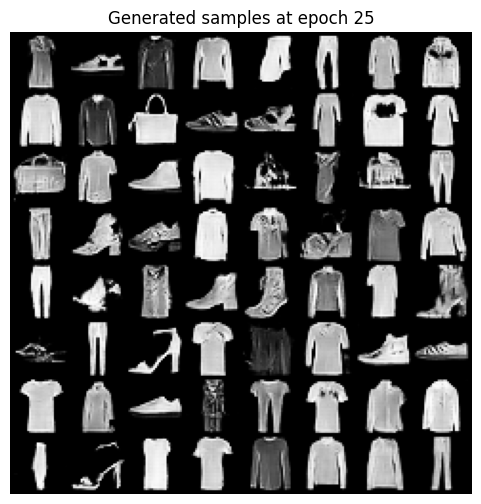

Epoch [26/30]  D_loss: 0.5274  G_loss: 1.8931


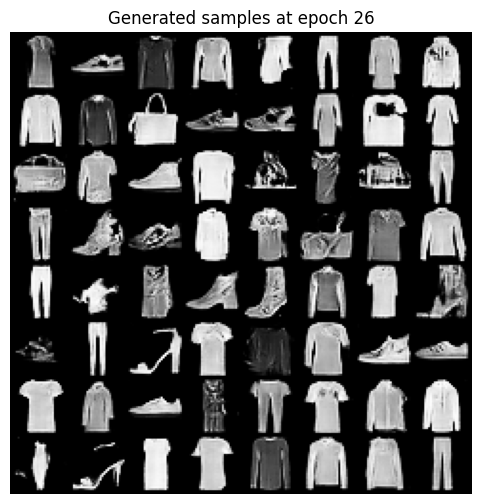

Epoch [27/30]  D_loss: 0.4867  G_loss: 1.8326


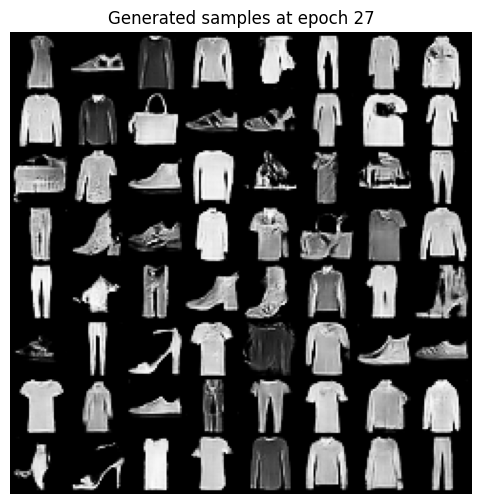

Epoch [28/30]  D_loss: 0.4630  G_loss: 2.9370


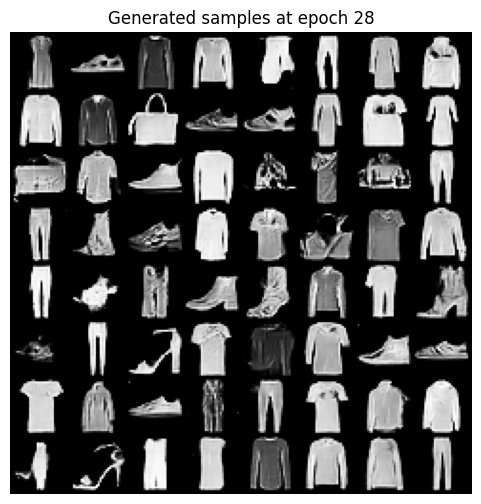

Epoch [29/30]  D_loss: 0.7727  G_loss: 1.7352


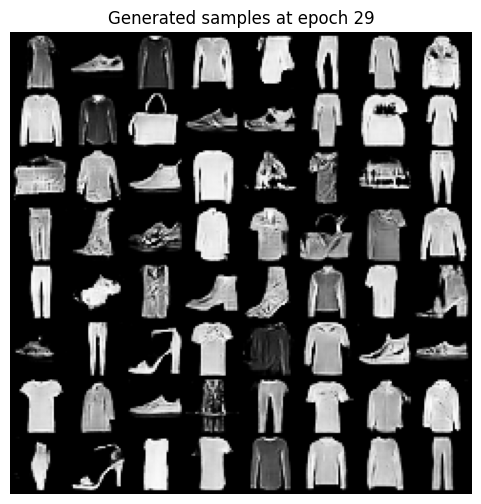

Epoch [30/30]  D_loss: 0.3692  G_loss: 1.9096


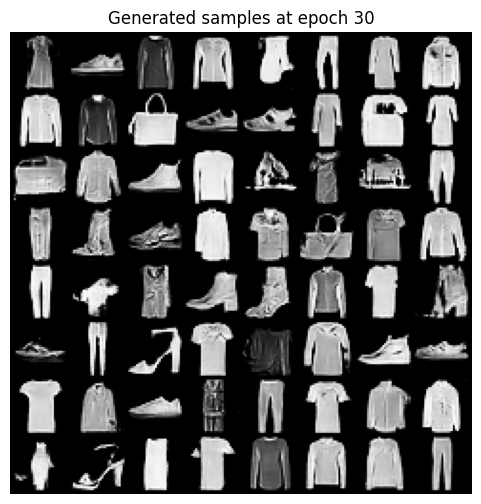

In [8]:
G.train()
D.train()

g_losses = []
d_losses = []

for epoch in range(1, num_epochs + 1):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)

        # --------------------
        #  Train Discriminator
        # --------------------
        optimizer_D.zero_grad()

        # Prepare real and fake labels for future train
        real_labels = torch.ones(real_imgs.size(0), 1, device=device) # array of 1s for the selected images
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device) # array of 0s for the to-be-generated images

        outputs_real = D(real_imgs)
        d_loss_real = criterion(outputs_real, real_labels)

        # Fake images
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(z) # generate from noise
        outputs_fake = D(fake_imgs) # what does the discriminator think?
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # ----------------
        #  Train Generator
        # ----------------
        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        # Generator wants D to think fakes are real (label = 1)
        g_loss = criterion(outputs, real_labels)

        # backward and steps...
        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # clear_output(wait=True)
    print(f"Epoch [{epoch}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")
    show_fake_samples(epoch, fixed_noise)

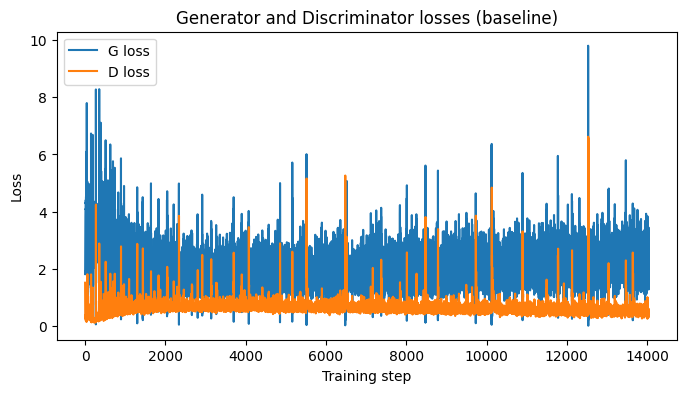

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(g_losses, label='G loss')
plt.plot(d_losses, label='D loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Generator and Discriminator losses (baseline)')
plt.legend()
plt.show()

In [10]:
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionV3Features(nn.Module):
    def __init__(self, device: torch.device):
        super().__init__()
        self.device = device
        inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        inception.eval()
        self.blocks = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        ).to(self.device)
        for param in self.blocks.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # If input is grayscale, repeat to 3 channels
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)

        x = (x + 1) / 2  # back to [0, 1]
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        # Inception normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)
        x = (x - mean) / std

        features = self.blocks(x)
        return features.view(features.size(0), -1)

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def get_features(images, model, device, max_samples=1000):
    model.eval()
    features_list = []
    n_samples = 0

    if isinstance(images, DataLoader):
        for batch in images:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]
            batch = batch.to(device)
            with torch.no_grad():
                feat = model(batch)
            features_list.append(feat.cpu().numpy())
            n_samples += batch.size(0)
            if n_samples >= max_samples:
                break
    else:
        images = images.to(device)
        with torch.no_grad():
            feat = model(images)
        features_list.append(feat.cpu().numpy())

    return np.concatenate(features_list, axis=0)[:max_samples]

# Initialize Inception model
inception_model = InceptionV3Features(device)

# 1. Compute statistics for real images
print("Computing statistics for real images...")
real_features = get_features(train_loader, inception_model, device, max_samples=1000)
mu_real = np.mean(real_features, axis=0)
sigma_real = np.cov(real_features, rowvar=False)

# 2. Generate fake images
print("Generating fake images for FID calculation...")
G.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim, device=device)
    fake_imgs = G(z)

# 3. Compute statistics for fake images
print("Computing statistics for fake images...")
fake_features = get_features(fake_imgs, inception_model, device, max_samples=1000)
mu_fake = np.mean(fake_features, axis=0)
sigma_fake = np.cov(fake_features, rowvar=False)

# 4. Calculate FID score
fid_score = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID Score: {fid_score:.4f}")


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 233MB/s] 


Computing statistics for real images...
Generating fake images for FID calculation...
Computing statistics for fake images...


/tmp/ipython-input-2438045073.py:59: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


FID Score: 36.4985
